<center>
    <p align="center">
        <img src="https://logodownload.org/wp-content/uploads/2017/09/mackenzie-logo-3.png" style="height: 7ch;"><br>
        <h1 align="center">Computer Systems Undergradute Thesis</h1>
        <h2 align="center">Quantitative Analysis of the Impact of Image Pre-Processing on the Accuracy of Computer Vision Models Trained to Identify Dermatological Skin Diseases</a>
        <h4 align="center">Gabriel Mitelman Tkacz</a>
        </h4>
    </p>
</center>

<hr>

In [1]:
import tomllib
from functools import partial
from pprint import pprint
from random import randint

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
from pynimbar import loading_animation
from torch.utils.data import DataLoader
from torchvision import transforms

from util import (BinaryCNN, EqualizationMethod,
                  LossFunction, SkinDiseaseDataset, TestingDataset,
                  TrainingDataset, split_datasets, test_model, train_model)

In [2]:
with open('parameters.toml', 'r') as f:
    parameters = tomllib.loads(f.read())
    
loading_handler = partial(loading_animation, break_on_error=True, verbose_errors=True, time_it_live=True)

pprint(parameters)

{'TRAINING': {'batch_size': 64,
              'diseased_skin_path': './dataset/diseased/',
              'healthy_skin_path': './dataset/healthy/',
              'learning_rate': 7.5e-05,
              'num_epochs': 15,
              'num_workers': 10,
              'pin_memory': True,
              'precision_threshold': 0.9,
              'shuffle': True,
              'training_dataset_ratio': 0.8}}


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
training_ratio = parameters['TRAINING']['training_dataset_ratio']
testing_ratio = round(1 - training_ratio, 1)

print(f'Training ratio: {training_ratio*100}%')
print(f'Testing ratio: {testing_ratio*100}%')

seed = 47
print(f'\nSeed: {seed}')


Training ratio: 80.0%
Testing ratio: 20.0%

Seed: 47


In [5]:
def get_model_data(transform: transforms.Compose = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])) -> tuple[TrainingDataset, DataLoader, TestingDataset, DataLoader]:
    """
    This function returns the training and testing data loaders and datasets for the skin disease dataset.

    Args:
        transform (transforms.Compose, optional): The transformations to apply to the images. Defaults to transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]).

    Returns:
        dict[str, dict[str, DataLoader | SkinDiseaseDataset]]: A dictionary containing the training and testing data loaders and datasets.
    """
    loader_kwargs = {
        'batch_size': parameters['TRAINING']['batch_size'],
        'shuffle': parameters['TRAINING']['shuffle'],
        'num_workers': parameters['TRAINING']['num_workers'],
        'pin_memory': parameters['TRAINING']['pin_memory']
    }

    base_dataset = SkinDiseaseDataset(root_dir='dataset', transform=transform)
    train_dataset, test_dataset = split_datasets(
        base_dataset, training_ratio, testing_ratio, seed)

    train_loader = DataLoader(train_dataset, **loader_kwargs)
    test_loader = DataLoader(test_dataset, **loader_kwargs)

    return train_dataset, train_loader, test_dataset, test_loader


def evaluate_model(device: torch.device, train_loader: DataLoader, test_loader: DataLoader, criterion: LossFunction = nn.BCELoss(), optimizer_class: type[optim.Optimizer] = optim.Adam, learning_rate: float = parameters['TRAINING']['learning_rate']) -> float:
    """
    This function evaluates the model using the given criterion and data loaders.

    Args:
        device (torch.device): The device to use for the evaluation.
        train_loader (DataLoader): The training data loader.
        test_loader (DataLoader): The testing data loader.
        criterion (LossFunction): The loss function to use for the evaluation. Defaults to nn.BCELoss().
        optimizer_class (type[optim.Optimizer], optional): The optimizer class to use for the evaluation. Defaults to optim.Adagrad.

    Returns:
        float: The accuracy of the model.
    """
    criterion = criterion.to(device)

    model = BinaryCNN(device=device).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate) # type: ignore

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle('Sample images from the training dataset')

    for i, (image, label) in enumerate(train_loader):
        ax[i].imshow(image[0].permute(1, 2, 0))
        ax[i].set_title(f'Label: {"diseased" if label[0] else "healthy"}')
        ax[i].axis('off')

        if i == 2:
            break

    clear_output(wait=True)
    plt.show()

    train_model(criterion=criterion, device=device, verbose=False,
                model=model, optimizer=optimizer, data_loader=train_loader)

    return test_model(model, test_loader, device)

## Class 0 Model: Images with no pre-processing

Evaluating the model on the base dataset... \ 41.16s

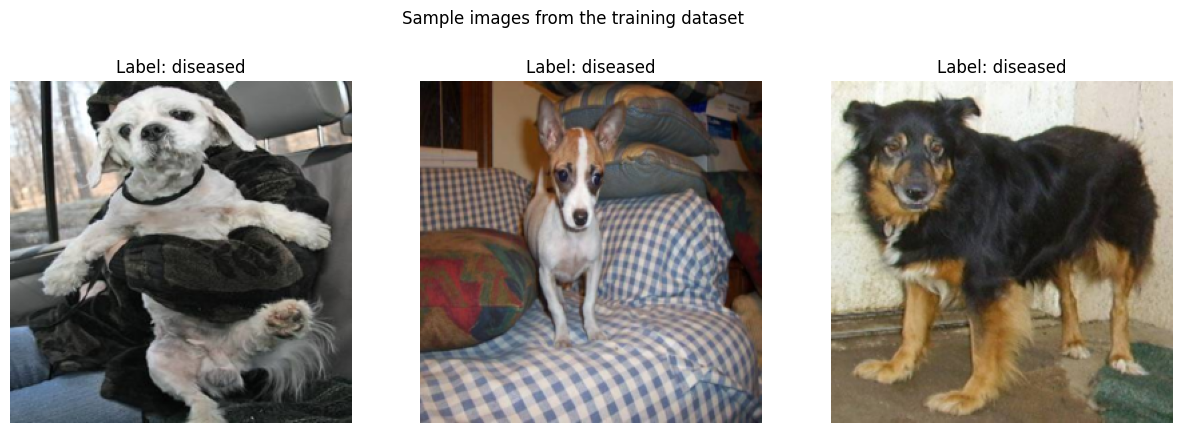

Evaluating the model on the base dataset... Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 2])) is deprecated. Please ensure they have the same size. (elapsed time: 81.22 seconds)


ValueError: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 2])) is deprecated. Please ensure they have the same size.

In [6]:
base_train_dataset, base_train_loader, base_test_dataset, base_test_loader = get_model_data()

with loading_handler(text='Evaluating the model on the base dataset...'):
    base_precision = evaluate_model(device, base_train_loader, base_test_loader)

print(f'Base precision: {base_precision*100:.2f}%')

## Class 1 Models: Images with only one pre-process

### Class 1.1 Models: Normalizing the image

In [ ]:
train_dataset, train_loader, test_dataset, test_loader = get_model_data(transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize(mean=[0.25, 0.25, 0.25], std=[0.25, 0.25, 0.25])]))

with loading_handler(text='Evaluating the model on a normalized dataset...'):
    precision = evaluate_model(device, train_loader, test_loader)

normalize_precision = precision

print(f'Precision: {precision*100:.2f}%')

print(f'Improvement: {100*(precision - base_precision):.2f}%')

if precision > base_precision:
    print('The method is an improvement.')

else:
    print('The method is not an improvement.')

print('-' * 20)
print()